In [1]:
import os
import time
import warnings
import numpy as np
import random as rnd
import pandas as pd
from collections import defaultdict

# Librería Genética
from deap import base, creator, tools, algorithms

from sklearn.utils import shuffle
# Subfunciones de estimadores
from sklearn.base import clone
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/base.py][30]
from sklearn.base import is_classifier
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/base.py][535]
from sklearn.model_selection._validation import _fit_and_score
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_validation.py][346]
from sklearn.model_selection._search import BaseSearchCV
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py][386]
from sklearn.model_selection._search import check_cv
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_split.py][1866]
from sklearn.model_selection._search import _check_param_grid
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py][343]
from sklearn.metrics.scorer import check_scoring
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/metrics/scorer.py][250]
from sklearn.utils.validation import _num_samples
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/validation.py][105]
from sklearn.utils.validation import indexable
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/validation.py][208]
from multiprocessing import Pool, Manager, cpu_count

# Selección para estimadores
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metricas para estimadores
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# Estimadores
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer

#Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#Ensembles algorithms
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
def set_config():
    top_conf = {}
    top_conf['LogisticRegression']	=	np.array([4, 1, 2, 3, 1])-1    
    top_conf['LinearDiscriminantAnalysis']	=	np.array([6, 1, 3, 3, 5])-1
    top_conf['GaussianNB']	=	np.array([4, 1, 2, 6, 1])-1
    top_conf['MLPClassifier']	=	np.array([4, 1, 4, 6, 1])-1
    top_conf['SVC']	=	np.array([6, 1, 6, 6, 1])-1#np.array([6, 6, 3, 3, 5])-1 #3
    top_conf['DecisionTreeClassifier']	=	np.array([6, 1, 3, 6, 5])-1#np.array([6, 1, 3, 3, 5])-1 #2
    top_conf['KNeighborsClassifier']	=	np.array([6, 1, 3, 6, 1])-1
    top_conf['RandomForestClassifier']	=	np.array([6, 1, 3, 3, 5])-1
    top_conf['ExtraTreesClassifier']	=	np.array([6, 1, 3, 3, 5])-1
    top_conf['GradientBoostingClassifier']	=	np.array([6, 1, 3, 3, 5])-1
    top_conf['AdaBoostClassifier']	=	np.array([6, 1, 3, 6, 5])-1#np.array([6, 1, 3, 3, 1])-1#6
    top_conf['VotingClassifier']	=	np.array([6, 1, 3, 3, 5])-1
    return top_conf
    
def set_models():
    rs = 1
    models = []
    models.append(('LogisticRegression', LogisticRegression(C=0.9, multi_class='multinomial', solver='newton-cg', warm_start=True)))
    # LDA : Warning(Variables are collinear)
    models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis(solver='eigen')))    
    models.append(('GaussianNB', GaussianNB(priors=None)))
    models.append(('MLPClassifier', MLPClassifier(hidden_layer_sizes=100, alpha=1e-05, activation='tanh', solver='adam', learning_rate='invscaling')))
    models.append(('SVC', SVC(random_state=rs, C=10, kernel='poly', decision_function_shape='ovo')))
    models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state=rs, max_features=None, splitter='best', criterion='entropy', class_weight=None, max_depth=10)))
    models.append(('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree')))
    
    models.append(('RandomForestClassifier', RandomForestClassifier(random_state=rs, max_depth=20, class_weight=None, max_features='sqrt', criterion='gini', warm_start=True, n_estimators=30)))
    # Bagging and Boosting
    # models.append(('ExtraTreesClassifier', ExtraTreesClassifier(n_estimators=150)))
    models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state=rs, max_depth=5, class_weight='balanced_subsample', min_samples_leaf=1, max_features='sqrt', max_leaf_nodes=9, criterion='gini', n_estimators=15)))
    
    # models.append(('AdaBoostClassifier', AdaBoostClassifier(DecisionTreeClassifier())))
    
    models.append(('GradientBoostingClassifier',GradientBoostingClassifier(random_state=rs, max_features='sqrt', learning_rate=0.1, max_depth=3, n_estimators=100)))
    models.append(('AdaBoostClassifier', AdaBoostClassifier(DecisionTreeClassifier(random_state=rs, max_features=None, splitter='best', criterion='entropy', class_weight=None, max_depth=10), 
                                                            n_estimators=500, algorithm='SAMME', learning_rate=2.0, random_state=rs)))
    # models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
    # Voting
    estimators = []
    estimators.append(("Voting_GradientBoostingClassifier",GradientBoostingClassifier(random_state=rs, max_features='sqrt', learning_rate=0.1, max_depth=3, n_estimators=100)))
    estimators.append(("Voting_ExtraTreesClassifier", ExtraTreesClassifier(random_state=rs, max_depth=5, class_weight='balanced_subsample', min_samples_leaf=1, max_features='sqrt', max_leaf_nodes=9, criterion='gini', n_estimators=15))) 
    voting = VotingClassifier(estimators, voting='soft')
    models.append(('VotingClassifier', voting))
    return models

test_size = 0.2
num_folds = 10
seed = 7
frecuencias = []
names_ = ['Be01', 'Be02', 'Be03', 'Be04', 'Be05', 'Sector']

frecuencias.append(pd.read_csv('sinFiltro/Tx_0x01'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x02'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x03'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x04'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x05'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x06'))#, names=names_))
"""
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx1.csv', names=names_))
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx2.csv', names=names_))
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx3.csv', names=names_))
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx4.csv', names=names_))
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx5.csv', names=names_))
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx6.csv', names=names_))
"""
num_jobs=cpu_count()
#estimadores = set_models()
#configuracion = set_models()
#salida = {}

In [19]:
# find distance error al 0.2%
def distance_error(estimator, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 7)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    # coord pred
    x1 = np.int32((y_pred + 2) % 3)
    y1 = np.int32((y_pred - 1) / 3)
    # coord real
    x2 = np.int32((y_test + 2) % 3)
    y2 = np.int32((y_test - 1) / 3)
    # pasar variacion a distancias metros
    vx = np.abs(x1 - x2)*1.5
    vy = np.abs(y1 - y2)*1.5
    #vx = vx*0.5 + (vx-1)*(vx>0)
    #vy = vy*0.5 + (vy-1)*(vy>0)
    # pitagoras
    err_distance = np.sqrt(vx*vx + vy*vy)
    return err_distance

#def _createDataset(frecuencias, values, seed = 7):
def _createDataset(frecuencias, values):
    from sklearn.utils import shuffle as shuff
    # crear dataset
    names_ = frecuencias[0].columns.values
    seed = 7
    # reestructuracion
    salida_final = pd.DataFrame(columns=names_)
    for sec in range(1,16):
        dataset = pd.DataFrame(columns=names_)
        corte = min([frecuencias[i][frecuencias[i]['Sector']==sec].shape[0] for i in values])
        #l = [frecuencias[i][frecuencias[i]['Sector']==sec].shape[0] for i in values]
        #corte = max(l)
        #tx=l.index(max(l))
        tx = 0
        dataset[names_[tx]] = dataset[names_[tx]].append(frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx]])
        dataset = dataset.reset_index(drop=True)
        for tx in range(1,5):
            dataset[names_[tx]] = frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx]].reset_index(drop=True)
        dataset[names_[tx+1]] = frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx+1]].reset_index(drop=True)
        # join parts
        salida_final = salida_final.append(dataset)
    # shuffle dataset
    salida_final = shuff(salida_final, random_state=seed).reset_index(drop=True)
    salida_final = salida_final.apply(pd.to_numeric)
    # dataframe to X,y 
    X = salida_final[names_[:-1]]
    y = salida_final[names_[-1]]
    return X,y

# The problem to optimize
def getAccuracy( frecuencias, individual, estimator, score_cache, resultados ):
	X,y = _createDataset(frecuencias, individual)
	score = 0
	scorer = "accuracy"
	name = str(estimator).split('(')[0]
	paramkey = name+str(np.int32(individual)+1)
	if paramkey in score_cache:
		score = score_cache[paramkey]
	else:
		print("Modeling ....",name)
		kfold = KFold(n_splits=10, shuffle=False)
		cv_results = cross_val_score(estimator, X, y, cv=kfold, scoring=scorer, n_jobs=-1)
		#print(name,"  ",paramkey,"   ")
		#print(len(X),"  ",len(y),"   ", kfold)
		score = cv_results.mean()
		desv = cv_results.std()
		error = distance_error(estimator, X, y)
		score_cache[paramkey] = score
		dict_result = {'Modelo': name, 'Configuracion':np.int32(individual)+1, 'values': cv_results, 'Accuracy': score, 'stdAccuracy': desv, 'errorMetrico': np.mean(error), 'error': error }
		resultados.append(dict_result)
	return score

In [4]:
def rename_order(dataframe_plot):
    previos = ['LogisticRegression', 'LinearDiscriminantAnalysis', 'GaussianNB', 'MLPClassifier', 
               'SVC', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'RandomForestClassifier', 
               'ExtraTreesClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'VotingClassifier']
    nuevos = ['LoR', 'LDA', 'GNB', 'MLP', 'SVC', 'DT', 'k-NN', 'RF', 'ET', 'GBM', 'AB', 'VC']
    num_models = len(nuevos)
    dataframe_plot = dataframe_plot[['Modelo', 'Configuracion', 'Accuracy', 'errorMetrico', 'values', 'error']]
    for i in range(num_models):
        dataframe_plot['Modelo'] = dataframe_plot['Modelo'].str.replace(previos[i], nuevos[i])
        #df['Modelo'] = df['Modelo'].str.replace('LinearDiscriminantAnalysis','LDA')
    sorterIndex = dict(zip(nuevos,range(num_models)))
    #test
    dataframe_plot['Model_Rank'] = dataframe_plot['Modelo'].map(sorterIndex)
    dataframe_plot = dataframe_plot.sort_values(['Model_Rank'],ascending=True).reset_index(drop=True)[dataframe_plot.columns[:-1]]
    return dataframe_plot

#dataframe_plot = topDf
def column_boxplot(dataframe_plot, column_plot, filename, box_bool=False):
    %pylab inline
    pylab.rcParams['figure.figsize'] = (14, 8)
    dataframe_plot = rename_order(dataframe_plot)
    nuevos = list(rename_order(topDf)['Modelo'])
    num_models = len(dataframe_plot)
    if column_plot == 'values':
        y_label = 'Score'
        x_label = 'Model'
    else:
        y_label = 'Error (m)'
        x_label = 'Model Evaluated'
    lista_plot = []
    for i in range(num_models):
        num_splits = len(list(dataframe_plot[column_plot])[i])
        for j in range(num_splits):
            d = {x_label:nuevos[i], y_label:dataframe_plot[column_plot][i][j]}
            lista_plot.append(d)
    #pd.DataFrame(lista_plot)
    sns.set_style("whitegrid")
    if column_plot == 'values':
        medians = np.round(list(dataframe_plot['Accuracy']),3)
        ax_plot = sns.boxplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
        tope = 1
        var_tope = 0.02
    else:
        #ax_plot = sns.barplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
        medians = np.round(list(dataframe_plot['errorMetrico']),3)
        if box_bool==True:
            ax_plot = sns.boxplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
            tope = 7
            var_tope = 0.2
        else:
            ax_plot = sns.barplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
            tope = 2
            var_tope = 0.1
    plt.format='eps'
    #
    import matplotlib as mplt
    ax_plot.set_xlabel(x_label,fontsize=18)
    ax_plot.set_ylabel(y_label,fontsize=18)
    mplt.rc('xtick', labelsize=15) 
    mplt.rc('ytick', labelsize=15)
    #
    median_labels = [str(s) for s in medians]
    pos = range(num_models)
    for tick,label in zip(pos,ax_plot.get_xticklabels()):
        ax_plot.text(pos[tick], tope-var_tope, median_labels[tick], 
                horizontalalignment='center', color='black', fontsize=15) #, weight='semibold'
    axes = plt.gca()
    if column_plot == 'values':
        axes.set_ylim([0.4, tope])
    else:
        axes.set_ylim([-0.1, tope])
    plt.savefig(filename + ".eps", bbox_inches='tight')    
    plt.show()


## Top Combinatorial

In [5]:
estimadores = set_models()
configuraciones = set_config()
score_cache = {}
resultados = []
lista_resultados = []
for name,model in estimadores:
    values = configuraciones[name]
    getAccuracy(frecuencias, values, model, score_cache, resultados)
    #lista_resultados = lista_resultados + list(a.resultados)
    #lista_resultados.append(b)

Modeling .... LogisticRegression
Modeling .... LinearDiscriminantAnalysis
Modeling .... GaussianNB
Modeling .... MLPClassifier
Modeling .... SVC
Modeling .... DecisionTreeClassifier
Modeling .... KNeighborsClassifier
Modeling .... RandomForestClassifier
Modeling .... ExtraTreesClassifier
Modeling .... GradientBoostingClassifier
Modeling .... AdaBoostClassifier
Modeling .... VotingClassifier


In [6]:
topDf = pd.DataFrame(resultados)
l_name = ['Modelo', 'Configuracion', 'Accuracy', 'stdAccuracy', 'errorMetrico']
topDf[l_name].to_csv('resultadosTOP1_gs.csv', sep=',', index=False)
display(topDf[l_name])

,Modelo,Configuracion,Accuracy,stdAccuracy,errorMetrico
0,LogisticRegression,"[4, 1, 2, 3, 1]",0.767090,0.020702,0.487357
1,LinearDiscriminantAnalysis,"[6, 1, 3, 3, 5]",0.775530,0.021650,0.481081
2,GaussianNB,"[4, 1, 2, 6, 1]",0.860133,0.017097,0.288983
3,MLPClassifier,"[4, 1, 4, 6, 1]",0.729389,0.016460,0.592527
4,SVC,"[6, 1, 6, 6, 1]",0.846696,0.024406,0.397719
5,DecisionTreeClassifier,"[6, 1, 3, 6, 5]",0.863971,0.014613,0.291408
6,KNeighborsClassifier,"[6, 1, 3, 6, 1]",0.878760,0.013432,0.248960
7,RandomForestClassifier,"[6, 1, 3, 3, 5]",0.905599,0.014214,0.201221
8,ExtraTreesClassifier,"[6, 1, 3, 3, 5]",0.808479,0.025425,0.435544
9,GradientBoostingClassifier,"[6, 1, 3, 3, 5]",0.918729,0.011251,0.179867


Populating the interactive namespace from numpy and matplotlib


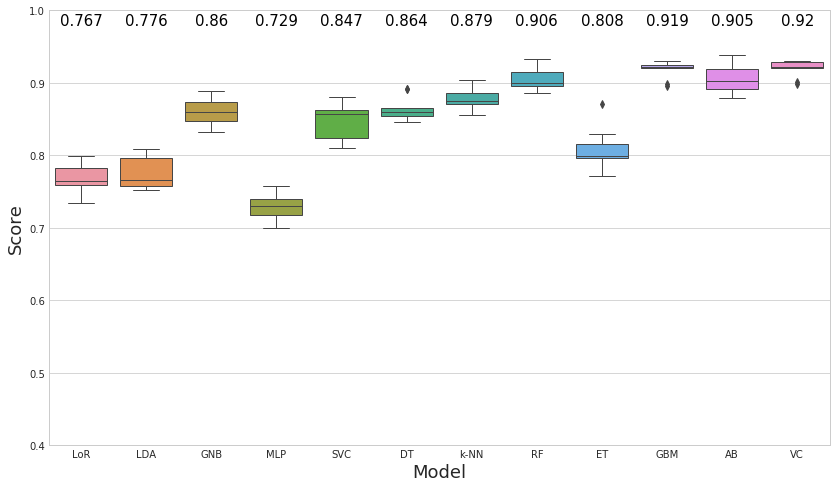

In [7]:
column_boxplot(topDf, 'values', 'accuracy_top1_gs')

Populating the interactive namespace from numpy and matplotlib


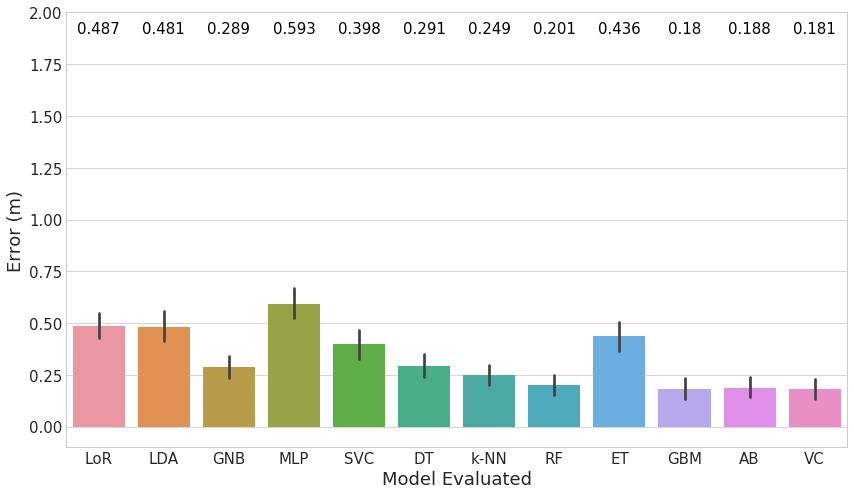

In [8]:
column_boxplot(topDf, 'error', 'error_top1_gs', box_bool = False)

## TOP EAS

In [18]:
def set_config():
    top_conf = {}
    top_conf['LogisticRegression']	=	np.array([4, 1, 2, 3, 1])-1    
    top_conf['LinearDiscriminantAnalysis']	=	np.array([6, 1, 3, 3, 5])-1
    top_conf['GaussianNB']	=	np.array([4, 1, 2, 6, 1])-1
    top_conf['MLPClassifier']	=	np.array([4, 1, 4, 6, 1])-1
    top_conf['SVC']	=	np.array([6, 6, 3, 3, 5])-1 #3
    top_conf['DecisionTreeClassifier']	=	np.array([6, 1, 3, 3, 5])-1 #2
    top_conf['KNeighborsClassifier']	=	np.array([6, 1, 3, 6, 1])-1
    top_conf['RandomForestClassifier']	=	np.array([6, 1, 3, 3, 5])-1
    top_conf['ExtraTreesClassifier']	=	np.array([6, 1, 3, 3, 5])-1
    top_conf['GradientBoostingClassifier']	=	np.array([6, 1, 3, 3, 5])-1
    top_conf['AdaBoostClassifier']	=	np.array([6, 1, 3, 3, 1])-1#6
    top_conf['VotingClassifier']	=	np.array([6, 1, 3, 3, 5])-1
    return top_conf

def set_models():
    rs = 1
    models = []
    models.append(('LogisticRegression', LogisticRegression(C=0.9, multi_class='multinomial', solver='newton-cg', warm_start=True)))
    # LDA : Warning(Variables are collinear)
    models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis(solver='eigen')))    
    models.append(('GaussianNB', GaussianNB(priors=None)))
    models.append(('MLPClassifier', MLPClassifier(hidden_layer_sizes=100, alpha=1e-05, activation='tanh', solver='adam', learning_rate='invscaling')))
    models.append(('SVC', SVC(random_state=rs, C=1, kernel='rbf', decision_function_shape='ovo')))
    models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state=rs, max_features=None, splitter='best', criterion='entropy', class_weight=None, max_depth=10)))
    models.append(('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree')))
    
    models.append(('RandomForestClassifier', RandomForestClassifier(random_state=rs, max_depth=20, class_weight=None, max_features='sqrt', criterion='gini', warm_start=True, n_estimators=30)))
    # Bagging and Boosting
    # models.append(('ExtraTreesClassifier', ExtraTreesClassifier(n_estimators=150)))
    models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state=rs, max_depth=5, class_weight='balanced_subsample', min_samples_leaf=1, max_features='sqrt', max_leaf_nodes=9, criterion='gini', n_estimators=15)))
    
    # models.append(('AdaBoostClassifier', AdaBoostClassifier(DecisionTreeClassifier())))
    
    models.append(('GradientBoostingClassifier',GradientBoostingClassifier(random_state=rs, max_features='sqrt', learning_rate=0.1, max_depth=3, n_estimators=100)))
    models.append(('AdaBoostClassifier', AdaBoostClassifier(DecisionTreeClassifier(random_state=rs, max_features=None, splitter='best', criterion='entropy', class_weight=None, max_depth=10), 
                                                            n_estimators=500, algorithm='SAMME.R', learning_rate=2.0, random_state=rs)))
    # models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
    # Voting
    estimators = []
    estimators.append(("Voting_GradientBoostingClassifier",GradientBoostingClassifier(random_state=rs, max_features='sqrt', learning_rate=0.1, max_depth=3, n_estimators=100)))
    estimators.append(("Voting_ExtraTreesClassifier", ExtraTreesClassifier(random_state=rs, max_depth=5, class_weight='balanced_subsample', min_samples_leaf=1, max_features='sqrt', max_leaf_nodes=9, criterion='gini', n_estimators=15))) 
    voting = VotingClassifier(estimators, voting='soft')
    models.append(('VotingClassifier', voting))
    return models

In [20]:
estimadores = set_models()
configuraciones = set_config()
score_cache = {}
resultados2 = []
lista_resultados2 = []
for name,model in estimadores:
    values = configuraciones[name]
    getAccuracy(frecuencias, values, model, score_cache, resultados2)
    #lista_resultados = lista_resultados + list(a.resultados)
    #lista_resultados.append(b)

Modeling .... LogisticRegression
Modeling .... LinearDiscriminantAnalysis
Modeling .... GaussianNB
Modeling .... MLPClassifier
Modeling .... SVC
Modeling .... DecisionTreeClassifier
Modeling .... KNeighborsClassifier
Modeling .... RandomForestClassifier
Modeling .... ExtraTreesClassifier
Modeling .... GradientBoostingClassifier
Modeling .... AdaBoostClassifier
Modeling .... VotingClassifier


In [21]:
topDf = pd.DataFrame(resultados2)
l_name = ['Modelo', 'Configuracion', 'Accuracy', 'stdAccuracy', 'errorMetrico']
topDf[l_name].to_csv('resultadosEAS1_gs.csv', sep=',', index=False)
display(topDf[l_name])

,Modelo,Configuracion,Accuracy,stdAccuracy,errorMetrico
0,LogisticRegression,"[4, 1, 2, 3, 1]",0.767090,0.020702,0.487357
1,LinearDiscriminantAnalysis,"[6, 1, 3, 3, 5]",0.775530,0.021650,0.481081
2,GaussianNB,"[4, 1, 2, 6, 1]",0.860133,0.017097,0.288983
3,MLPClassifier,"[4, 1, 4, 6, 1]",0.722183,0.024338,0.613235
4,SVC,"[6, 6, 3, 3, 5]",0.829563,0.017179,0.511966
5,DecisionTreeClassifier,"[6, 1, 3, 3, 5]",0.858025,0.018358,0.326339
6,KNeighborsClassifier,"[6, 1, 3, 6, 1]",0.878760,0.013432,0.248960
7,RandomForestClassifier,"[6, 1, 3, 3, 5]",0.905599,0.014214,0.201221
8,ExtraTreesClassifier,"[6, 1, 3, 3, 5]",0.808479,0.025425,0.435544
9,GradientBoostingClassifier,"[6, 1, 3, 3, 5]",0.918729,0.011251,0.179867


Populating the interactive namespace from numpy and matplotlib


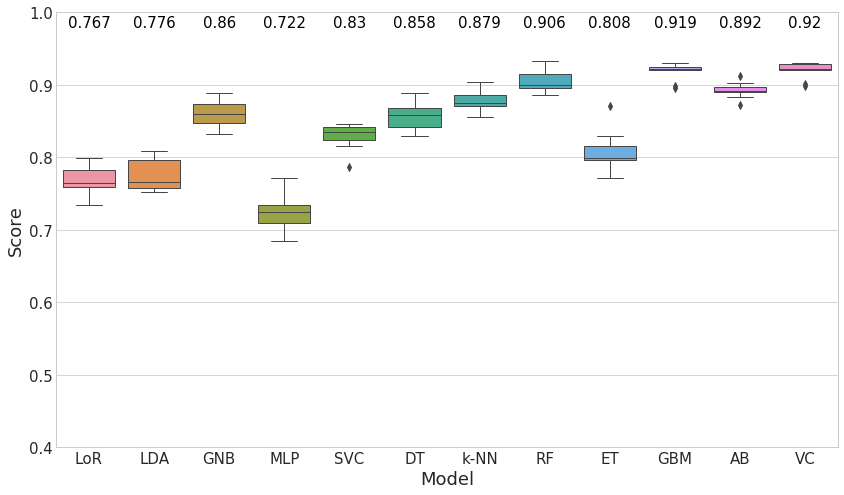

In [22]:
column_boxplot(topDf, 'values', 'accuracy_eas1_gs')

Populating the interactive namespace from numpy and matplotlib


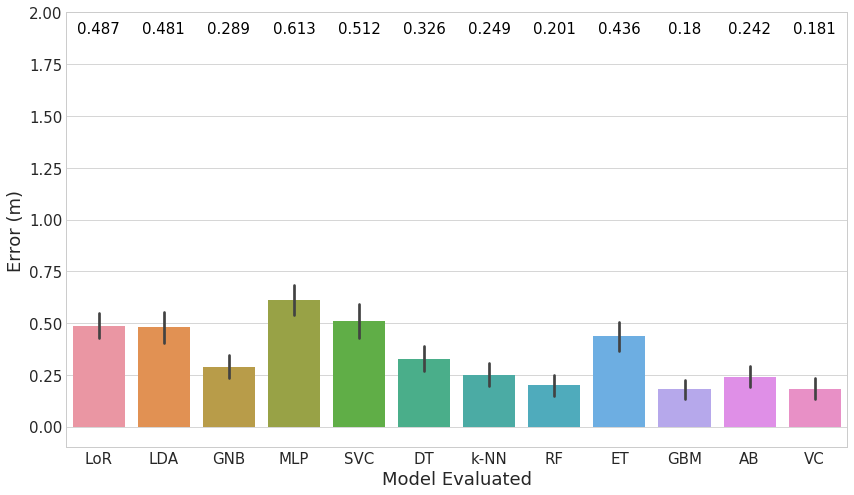

In [23]:
column_boxplot(topDf, 'error', 'error_eas1_gs', box_bool = False)